# For testing during the dev process

## 1. INITIALIZATION

In [1]:
import deeptrack
import DT_extension_dev as DTE

Using TensorFlow backend.


## Image generation


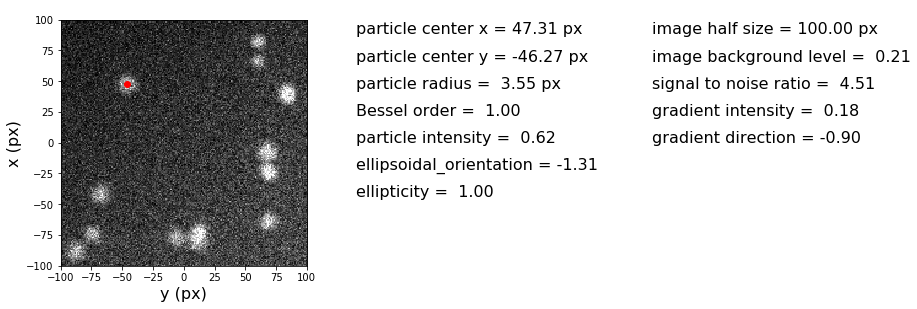

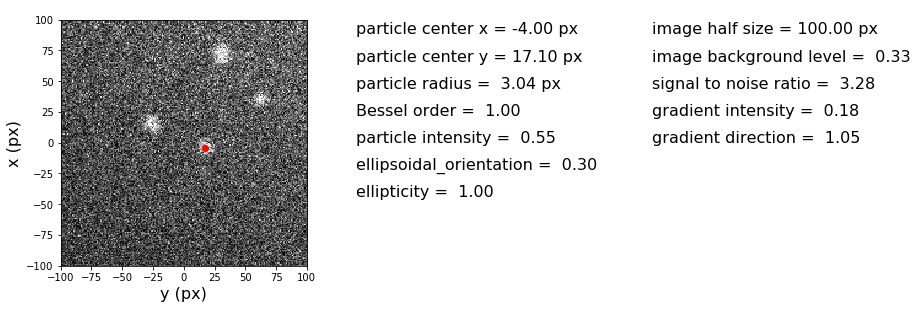

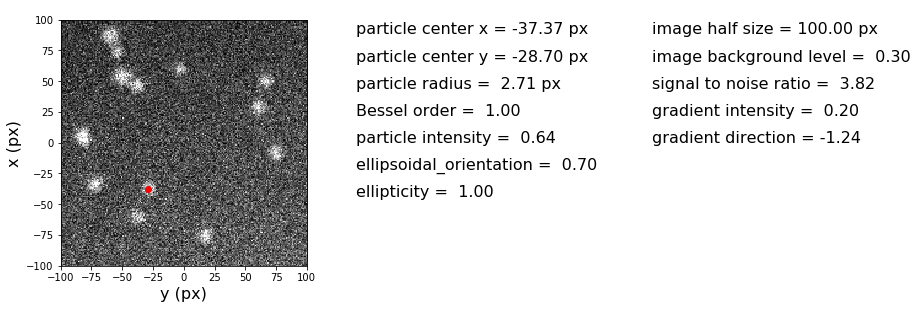

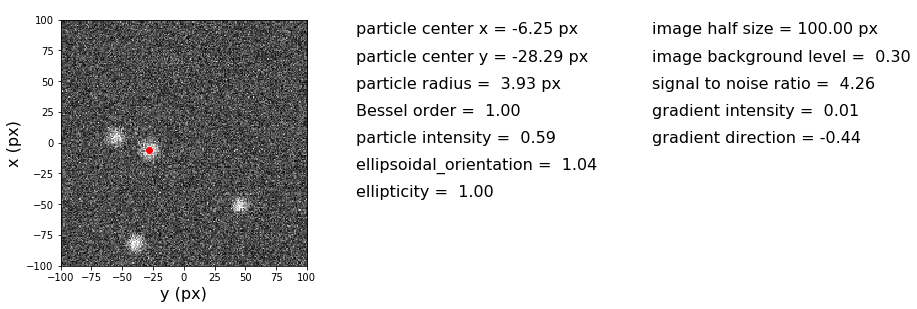

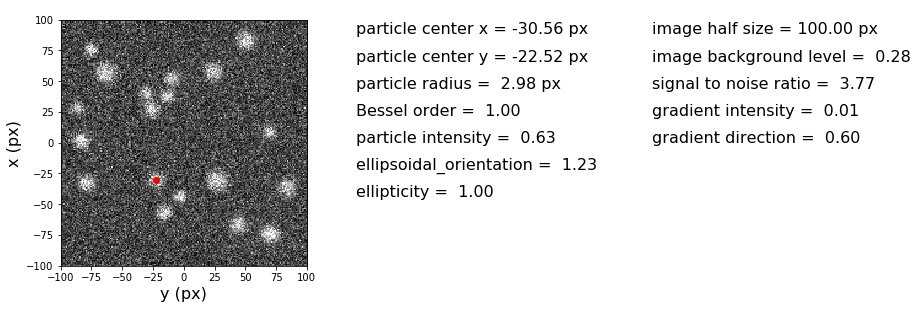

In [2]:
### Define image properties
%matplotlib inline
from numpy.random import randint, uniform, normal, choice


def get_image_parameters_optimized():
    import deeptrack
    from numpy.random import randint, uniform, normal, choice
    from math import pi, floor
    
    
    particle_number = floor(uniform(2,25))
    first_particle_range = 50
    other_particle_range = 90
    particle_distance = 10
    
    (particles_center_x, particles_center_y) = deeptrack.particle_positions(particle_number, first_particle_range, other_particle_range, particle_distance)
    image_parameters = {}

    image_parameters['Particle Center X List'] = particles_center_x
    image_parameters['Particle Center Y List'] = particles_center_y
    image_parameters['Particle Radius List'] = uniform(2.5, 4, particle_number)
    
    
    mylist = []
    for i in range(particle_number):
        mylist.append([1, ])
    
    image_parameters['Particle Bessel Orders List'] = mylist
    
    mylist2 = []
    for i in range(particle_number):
        mylist2.append([uniform(0.5,0.7,1), ])
    
    image_parameters['Particle Intensities List'] = mylist2
    
    image_parameters['Image Half-Size'] = 100
    image_parameters['Image Background Level'] = uniform(.2, .4)
    image_parameters['Signal to Noise Ratio'] = uniform(3,6)
    image_parameters['Gradient Intensity'] = uniform(0, 0.2)
    image_parameters['Gradient Direction'] = uniform(-pi, pi)
    image_parameters['Ellipsoid Orientation'] = uniform(-pi, pi, particle_number)
    image_parameters['Ellipticity'] = 1
    
    return image_parameters

image_parameters_function = lambda : get_image_parameters_optimized()

### Define image generator
image_generator = lambda : DTE.get_image_generator(image_parameters_function)

### Show some examples of generated images
number_of_images_to_show = 5


for image_number, image, image_parameters, target in image_generator():
    if image_number>=number_of_images_to_show:
        break
    
    deeptrack.plot_sample_image(image, image_parameters)
    DTE.get_target_binary_image(image_parameters)

## 3. CREATE AND COMPILE DEEP LEARNING NETWORK

The parameters of the deep learning network are defined and the network created. The summary of the network is printed where the output shape and number of parameters for each layer can be visualized.  

Comments:
1. The parameter <strong>input_shape</strong> determines the shape of the input image (x-pixels by y-pixels by color channels).
2. The parmameter <strong>conv_layers_dimensions</strong> determines the number and size of convolutional layers.
3. The parameter <strong>dense_layers_dimensions</strong> determines the number and size of dense layers.

In [7]:
### Define parameters of the deep learning network
input_shape = (256, 256, 1) # Change to determine the shape of the input image [x-pixels by y-pixels by color channels]
#conv_layers_dimensions = (16, 32, 64) # Change to determine the number and size of convolutional layers
#dense_layers_dimensions = (32, 32) # Change to determine the numebr and size of dense layers

### Create deep learning network
network = DTE.create_unet(input_size=input_shape)

### Print deep learning network summary
network.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            (None, 256, 256, 1)  0                                            
__________________________________________________________________________________________________
zero_padding2d_5 (ZeroPadding2D (None, 256, 256, 1)  0           input_5[0][0]                    
__________________________________________________________________________________________________
conv2d_71 (Conv2D)              (None, 256, 256, 64) 640         zero_padding2d_5[0][0]           
__________________________________________________________________________________________________
conv2d_72 (Conv2D)              (None, 256, 256, 64) 36928       conv2d_71[0][0]                  
____________________________________________________________________________________________

## 4. TRAIN DEEP LEARNING NETWORK

The parameters for the training of the deep learning network are defined and the network is trained. The sample size, iteration number, MSE, MAE and the time of each iteration is printed.

Comments:
1. The parameter <strong>sample_sizes</strong> determines the sizes of the batches of images used in the training.
2. The parameter <strong>iteration_numbers</strong> determines the numbers of batches used in the training.
3. The parameter <strong>verbose</strong> determines the frequency of the update messages. It can be either a boolean value (True/False) or a number between 0 and 1.

In [ ]:
### Define parameters of the training
sample_sizes = (8, 16)
iteration_numbers = (20, 10)
verbose = 1

### Training
training_history = DTE.train_deep_learning_network(network, image_generator, sample_sizes, iteration_numbers, verbose)

## 5. PLOT LEARNING PERFORMANCE

The learning performance is plotted. The MSE, MAE, sample size, iteration number and iteration time are plotted against the number of timesteps. 

Comment:
1. The parameter <strong>number_of_timesteps_for_average</strong> determines the length of the average. It must be a positive integer number.

In [ ]:
### Plot learning performance
#number_of_timesteps_for_average = 100
#deeptrack.plot_learning_performance(training_history, number_of_timesteps_for_average)

def predict_generated_image(network, image_generator, n = 5):
    import deeptrack as dt
    from numpy import reshape
    import matplotlib.pyplot as plt
    import matplotlib.image as mpimg
    
    image_shape = network.get_layer(index=0).get_config()['batch_input_shape'][1:]

    for image_number, image, image_parameters, target in image_generator():
        if image_number>=n:
            break
        resized_image = dt.resize_image(image, (image_shape[0], image_shape[1]))
        prediction = network.predict(reshape(resized_image, (1, image_shape[0], image_shape[1], image_shape[2])))                      
                
        dt.plot_sample_image(image, image_parameters)
        dt.plot_sample_image(target, image_parameters)
        imgplot = plt.imshow(prediction.reshape((image_shape[0],image_shape[1])))
    
predict_generated_image(network, image_generator)

## 6. TEST DEEP LEARNING NETWORK ON NEW SIMULATED DATA

The deep learning network is tested on new simulated data (parameters are defined in [section 2](#sec2)). 

Comments:
1. The parameter <strong>number_of_predictions_to_show</strong> determines the number of predictions that are shown.
3. The <font color=red><strong>red<strong></font> symbol superimposed to the images represents the ground truth particle position.
4. The <font color='#e6661a'><strong>orange<strong></font> symbol is the deep learning network prediction for the position (x, y), and the circle is the prediction for the radial distance r. 

In [ ]:
### Test the predictions of the deep learning network on some generated images
number_of_predictions_to_show = 10

for image_number, image, image_parameters in image_generator():
    if image_number>=number_of_predictions_to_show:
        break
    
    predicted_position = deeptrack.predict(network, image)
    
    deeptrack.plot_prediction(image, image_parameters, predicted_position)

## 7. SAVE DEEP LEARNING NETWORK

Comments:
1. The parameter <strong>save_file_name</strong> is the name of the file where the deep learnign network is saved.
2. By default, the network is saved in the same folder where DeepTrack 1.0 is running.

In [ ]:
### Prepare file name
from datetime import datetime as time

save_file_name = 'Network ' + time.now().strftime('%Y-%m-%d-%H%M%S')

save_file_name += ' C'
for conv_layer_dimension in conv_layers_dimensions:
    save_file_name += '-' + str(conv_layer_dimension)

save_file_name += ' D'
for dense_layer_dimension in dense_layers_dimensions:
    save_file_name += '-' + str(dense_layer_dimension)

save_file_name += ' training'
for sample_size, iteration_number in zip(sample_sizes, iteration_numbers):
    save_file_name += '-' + str(sample_size) + 'x' + str(iteration_number)

save_file_name += '.h5'

### Save deep learning model
import os

if not os.path.exists(save_file_name):
    network.save(save_file_name)
    print('Saved deep learning network as:')
    print(save_file_name)